# Experiments on Phylo HMMs

In [10]:
%matplotlib inline
from tree_serialisation import load_tree
from data_simulation import generate_case, rate_sub_HKY, scale_branches_length

import numpy as np
import random
from copy import deepcopy

import matplotlib.pyplot as plt

from felsenstein import pruning
from viterbi_sumproduct import viterbi, sum_product
from model_evaluation import sub_tree, single_decoding_routine

## First example a toy gene finder

In [11]:
# SIMULATION PARAMETERS
tree_path = "tree.json"
alphabet = ['A', 'C', 'T', 'G']
alphabetSize = len(alphabet)

nbState = 4
# transition matrix of the toy gene finder
A = np.zeros((nbState, nbState))
A[0, 1] = 1
A[1, 2] = 1
A[2, 3] = 0.10
A[2, 0] = 1 - A[2, 3]
A[3, 3] = 0.8  # 0.9999  # unrealistic ...
A[3, 0] = 1 - A[3, 3]

# state initial probability
b = np.array([0.25, 0.25, 0.26, 0.24])

animalNames = ["dog", "cat", "pig", "cow", "rat", "mouse", "baboon", "human"]
n_species = len(animalNames)
"""[...], such as the higher average rate of substitution and the greater
transition/transversion ratio, in noncoding and third-codon-position sites
than in firstand second- codon-position sites[...]"""

#pi = np.random.uniform(0.15, 0.35, (nbState, alphabetSize))
pi = np.random.rand(nbState, alphabetSize).reshape(nbState, alphabetSize)
pi /= pi.sum(axis=1)[:, None]

# translation/transversion rate
kappa = np.array([2.3, 2.7, 4.3, 5.4])

In [12]:
# MONTE-CARLO PARAMETERS
n_nucleotids = 1000
n_simulations = 50

In [13]:
np.seterr(all='warn')
precision = np.zeros((n_simulations, n_species))
sensitivity = np.zeros((n_simulations, n_species))
specificity = np.zeros((n_simulations, n_species))
for n in range(n_simulations):
    for i,sub_indices in enumerate(
        [[5],[1,5],[1,4,5],[1,4,5,8],[1,2,4,5,8],[1,2,3,4,5,8],[1,2,3,4,5,7,8],range(1,9)]):
    
        precision[n, i], sensitivity[n, i], specificity[n, i] = single_decoding_routine(tree_path, n_nucleotids, alphabet, A,
                            b, n_species, pi, kappa, alg='viterbi',
                            list_of_species=sub_indices)
        # Precision

    print("Simulation n°{:d}".format(n))

C:\Users\Pierre\Downloads\MVA\phylo-hmm\viterbi_sumproduct.py:49: RuntimeWarning: divide by zero encountered in log
  prob = np.log(A[:, s]) + alpha_log[:, t - 1]


Simulation n°0
Simulation n°1
Simulation n°2
Simulation n°3
Simulation n°4
Simulation n°5
Simulation n°6
Simulation n°7
Simulation n°8
Simulation n°9
Simulation n°10
Simulation n°11
Simulation n°12
Simulation n°13
Simulation n°14
Simulation n°15
Simulation n°16
Simulation n°17
Simulation n°18
Simulation n°19
Simulation n°20
Simulation n°21
Simulation n°22
Simulation n°23
Simulation n°24
Simulation n°25
Simulation n°26
Simulation n°27
Simulation n°28
Simulation n°29
Simulation n°30
Simulation n°31
Simulation n°32
Simulation n°33
Simulation n°34
Simulation n°35
Simulation n°36
Simulation n°37
Simulation n°38
Simulation n°39
Simulation n°40
Simulation n°41
Simulation n°42
Simulation n°43
Simulation n°44
Simulation n°45
Simulation n°46
Simulation n°47
Simulation n°48
Simulation n°49


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:504: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


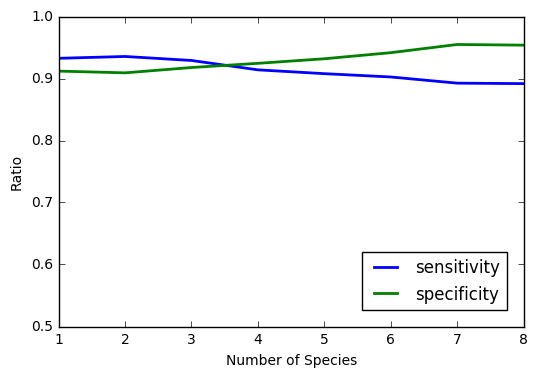

In [30]:
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0.5, 1])
plt.ylabel('Ratio')
plt.xlabel('Number of Species')
handles= [
    #plt.plot(range(1, n_species+1), precision.mean(axis=0),
    #         linewidth=2),
    plt.plot(range(1, n_species+1), sensitivity.mean(axis=0),
             linewidth=2),
    plt.plot(range(1, n_species+1), specificity.mean(axis=0),
             linewidth=2)
    ]
plt.legend(handles, labels=["sensitivity", "specificity"], #labels=["precision", "sensitivity", "specificity"],
           loc=4, borderaxespad=1)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:504: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


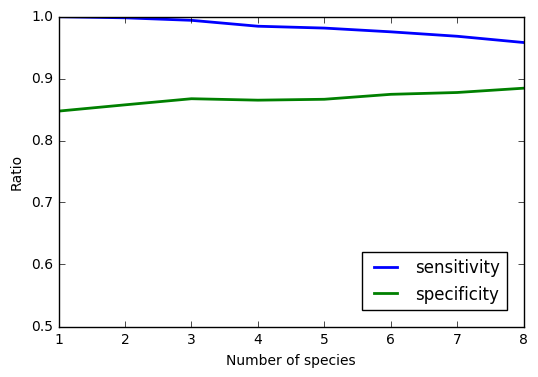

In [29]:
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0.5, 1])
plt.xlabel('Number of species')
plt.ylabel('Ratio')
handles= [
    #plt.plot(range(1, n_species+1), precision.mean(axis=0),
    #         linewidth=2),
    plt.plot(range(1, n_species+1), sensitivity_unif.mean(axis=0),
             linewidth=2),
    plt.plot(range(1, n_species+1), specificity_unif.mean(axis=0),
             linewidth=2)
    ]
plt.legend(handles, labels=["sensitivity", "specificity"],
           loc=4, borderaxespad=1.)